# Import libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme(style="whitegrid")

import plotly.express as px

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from utils import eda_train_path

# Load datasets

In [2]:
train_df = pd.read_csv(eda_train_path)

# Notes

- Сильная отрицательная линейная корреляция valid_miles и rate (-0.698).
- Слабая линейная корреляция weight и rate (-0.118).
- Почти нулевая линейная корреляция transport_type и rate (0.024).
Вопросы:
- Нужно ли учитывать valid_miles в модели напрямую, или лучше использовать трансформации?
- Если transport_type не коррелирует с rate, стоит ли его вообще использовать?
- Как проверить, есть ли нелинейные корреляции, которых нет в стандартной корреляционной матрице?
- Есть ли нелинейные зависимости между rate и другими переменными?
- Как использовать эту информацию при построении модели?

- Обычная корреляция (Pearson) → измеряет только линейные зависимости.
- Spearman-корреляция → измеряет монотонные зависимости (линейные + нелинейные).
- Mutual Information (MI) → измеряет любые зависимости (включая сложные нелинейные).


|Признак|Pearson Corr с `rate`|Spearman Corr с `rate`|Mutual Information (`rate`)|
|---|---|---|---|
|`valid_miles`|-0.698|-0.6983|5.3896|
|`weight`|-0.118**|-0.1181|1.0227|
|`transport_type`|0.024|–|–|


- Pearson и Spearman для valid_miles практически совпадают (-0.698).
- Это значит, что зависимость valid_miles и rate линейная или близкая к монотонной.
- MI для valid_miles = 5.38, что подтверждает, что связь сильная, но, возможно, есть слабая нелинейность.
- Для weight тоже нет разницы между Pearson и Spearman (-0.118), а MI всего 1.02.
- Это значит, что weight влияет на rate, но намного слабее, чем valid_miles.
- Если бы weight имел сильную нелинейную зависимость, MI был бы значительно больше.
- transport_type имеет почти нулевую линейную корреляцию (0.024).
- Это значит, что он либо не влияет на rate, либо его влияние сложное и скрытое (категориальная зависимость).

Выводы:
- valid_miles – ключевой признак, он сильнее всего связан с rate.
    - Зависимость между rate и valid_miles почти линейная, но с небольшими нелинейными эффектами (MI = 5.38).
    - Это значит, что модель должна учитывать valid_miles напрямую, возможно, с трансформацией (например, логарифмом).
- weight влияет на rate, но значительно слабее.
    - Его влияние больше нелинейное, чем линейное (MI = 1.02).
    - Это значит, что в модели может помочь полиномиальный или логарифмический признак.
- transport_type не имеет линейной зависимости с rate, но это не значит, что он бесполезен.
    - Он категориальный и, возможно, влияет на rate через сложные зависимости.
    - Значит, его лучше анализировать через группировки и кодирование (one-hot, target encoding, embeddings).


# Mutual Information

In [3]:
def calculate_mi(train_df):
    num_features = ["valid_miles", "weight"]
    X = train_df[num_features]
    y = train_df["rate"]

    mi_scores = mutual_info_regression(X, y, random_state=42)
    mi_scores = pd.Series(mi_scores, index=num_features)

    print("Mutual Information (нелинейная зависимость с rate):")
    print(mi_scores.sort_values(ascending=False))

    spearman_corr = train_df[["rate", "valid_miles", "weight"]].corr(method="spearman")
    print("Spearman Correlation (монотонная зависимость):")
    print(spearman_corr)

In [4]:
calculate_mi(train_df)

Mutual Information (нелинейная зависимость с rate):
valid_miles    5.327568
weight         0.911912
dtype: float64
Spearman Correlation (монотонная зависимость):
                 rate  valid_miles    weight
rate         1.000000    -0.701286 -0.112271
valid_miles -0.701286     1.000000  0.216142
weight      -0.112271     0.216142  1.000000


# MI for transport_type

In [5]:
train_df["transport_type_encoded"] = LabelEncoder().fit_transform(train_df["transport_type"])
mi_transport = mutual_info_regression(train_df[["transport_type_encoded"]], train_df["rate"])
print("MI for transport_type:", mi_transport[0])

MI for transport_type: 0.12440606406261567


# `valid_miles` bar plot

<Axes: xlabel='valid_miles_bin'>

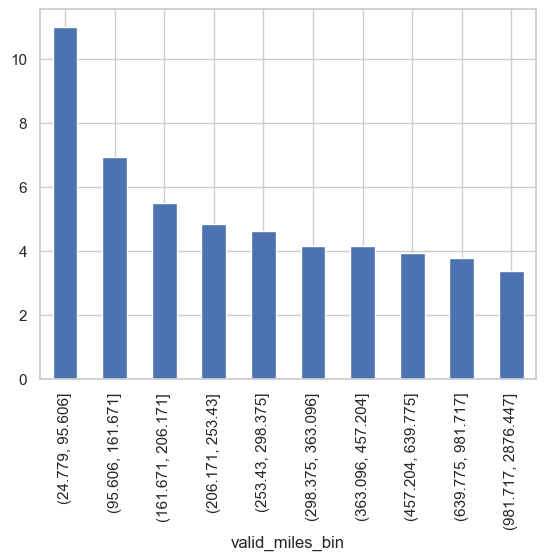

In [6]:
train_df["valid_miles_bin"] = pd.qcut(train_df["valid_miles"], q=10)
train_df.groupby("valid_miles_bin", observed=True)["rate"].mean().plot(kind="bar")

- rate сильно падает на коротких расстояниях (до ~100 миль).
- После ~200 миль снижение rate замедляется.
- После ~500 миль rate почти стабилен.
- Зависимость не линейная, а скорее степенная (то есть rate уменьшается, но не пропорционально valid_miles).
- Это идеальный случай для логарифмической трансформации.

# Полиномиальные признаки

In [7]:
X = train_df[["valid_miles", "weight"]]
y = train_df["rate"]

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)

r2 = model.score(X_poly, y)
print("R² for polynomial regression:", r2)

R² for polynomial regression: 0.2933862097311303


- R² = 0.294 → модель объясняет только 29.4% дисперсии rate.
- Это очень низкий показатель для полиномиальной регрессии.
- Полиномиальные признаки не дают сильного улучшения модели.

- Логарифмировать valid_miles вместо полиномов.
- Попробовать взаимодействие valid_miles и weight.
- Добавить KMA-локации (origin_kma, destination_kma), потому что они могут влиять на rate.

# `transport_type` bar plot

<Axes: xlabel='transport_type'>

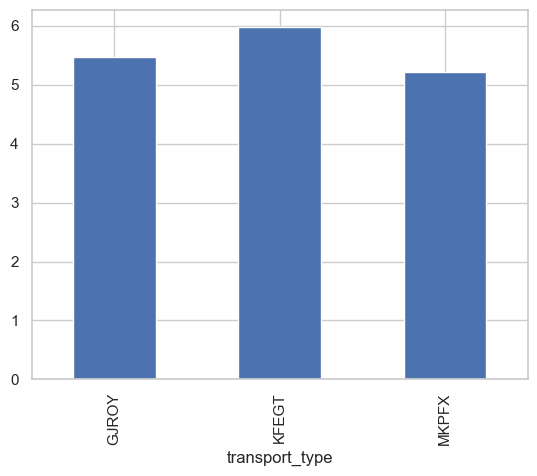

In [9]:
train_df.groupby("transport_type")["rate"].mean().plot(kind="bar")

Что показывает график?
- Средний rate немного отличается между transport_type, но разница небольшая.
- KFEGT чуть выше (~6.5).
- MKPFX и GJROY примерно одинаковы (~5.2).
- MI = 0.136 → это низкое значение, что подтверждает, что transport_type не является ключевым фактором.
- Можно попробовать Target Encoding вместо One-Hot Encoding, чтобы не увеличивать размерность данных.
- Если transport_type не улучшит модель, его можно исключить.

# MI for transport_type for encoded `transport_type`

In [13]:
train_df["transport_type_encoded"] = LabelEncoder().fit_transform(train_df["transport_type"])
mi_transport = mutual_info_regression(train_df[["transport_type_encoded"]], train_df["rate"])
print("MI for transport_type:", mi_transport[0])

MI for transport_type: 0.1253839392017122
